In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Open the FITS file
path = "/Users/wasi/Downloads/Castor-Madeline/CASTOR_AaronsCat_wide4_2019PSFs__FOV0_g_18000s_pixscale0p1.fits"
hdul = fits.open(path)
hdul.info()

# Check the data shape and header
print(hdul[0].header)


Filename: /Users/wasi/Downloads/Castor-Madeline/CASTOR_AaronsCat_wide4_2019PSFs__FOV0_g_18000s_pixscale0p1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   (15840, 20160)   float32   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                15840                                                  NAXIS2  =                20160                                                  EXTEND  =                    T                                                  GS_XMIN =                    1 / GalSim image minimum x coordinate              GS_YMIN =                    1 / GalSim image minimum y coordinate              GS_WCS  = 'GSFitsWCS'          / GalSim WCS name                                CTYPE1  = 'RA---TAN'                

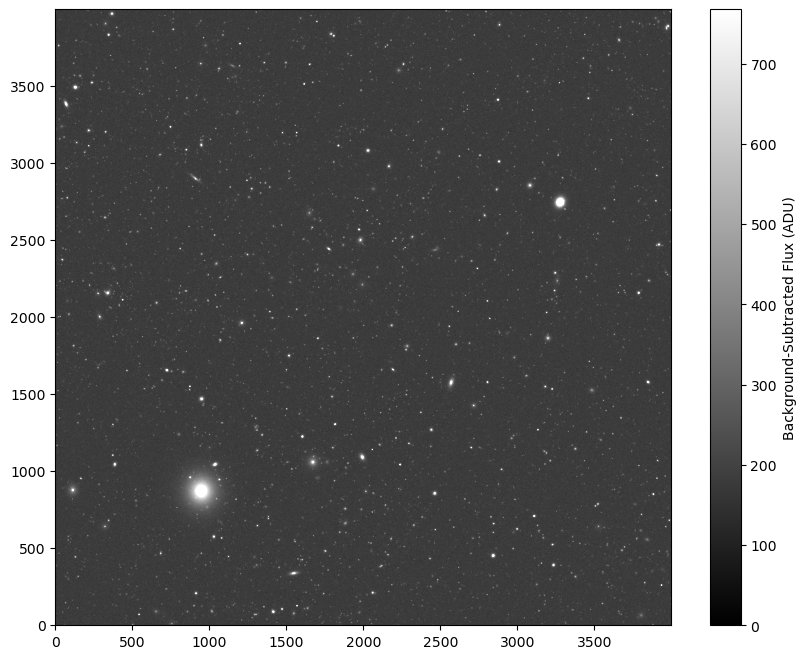

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.background import Background2D, MedianBackground

# Load the FITS file
path = "/Users/wasi/Downloads/Castor-Madeline/CASTOR_AaronsCat_wide4_2019PSFs__FOV0_g_18000s_pixscale0p1.fits"
with fits.open(path, memmap=True) as hdul:
     hdul[0].data[5000:7000, 11000:13000].astype('float32') # Reduce memory usage
     data = np.clip(np.nan_to_num(hdul[0].data[3000:7000, 10000:14000].astype('float32')),0,None)

#bkg_estimator = MedianBackground()
#bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
#data_sub = data - bkg.background
# Visualize the preprocessed image
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='gray', origin='lower', vmin=0, vmax=np.percentile(data, 99.9))
plt.colorbar(label='Background-Subtracted Flux (ADU)')
plt.show()

In [23]:
from photutils.detection import find_peaks

# Find the brightest pixel (galaxy center)
peaks = find_peaks(data, threshold=5 * np.std(data))  # Adjust threshold
x_peak, y_peak = peaks['x_peak'][0], peaks['y_peak'][0]
print(f"Galaxy center (x, y): ({x_peak:.1f}, {y_peak:.1f})")

Galaxy center (x, y): (2462.0, 0.0)


Estimated Galaxy Center: (305.95, 920.22)


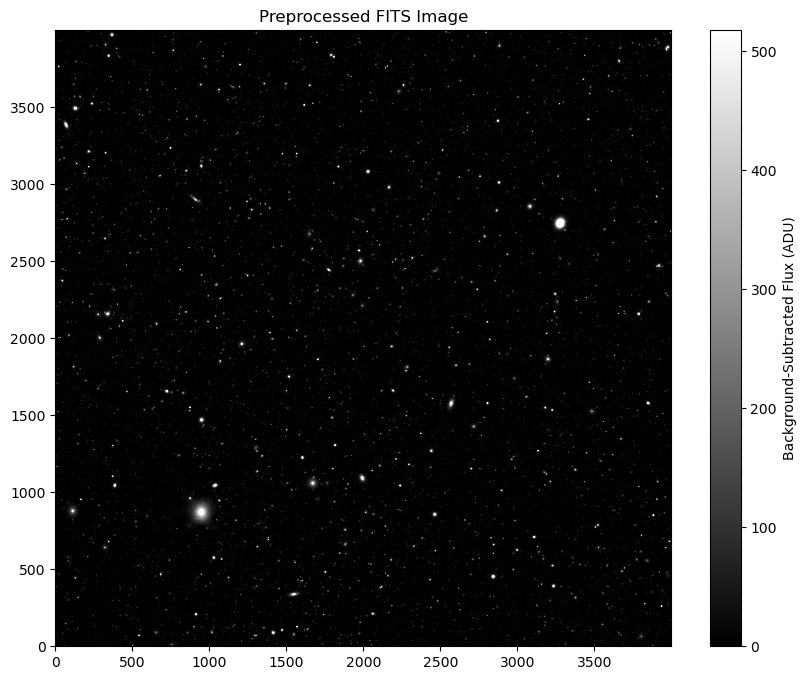

Best-fit Sérsic index (n): 0.42
Effective radius (r_eff): 1.08 pixels
Ellipticity: -0.21


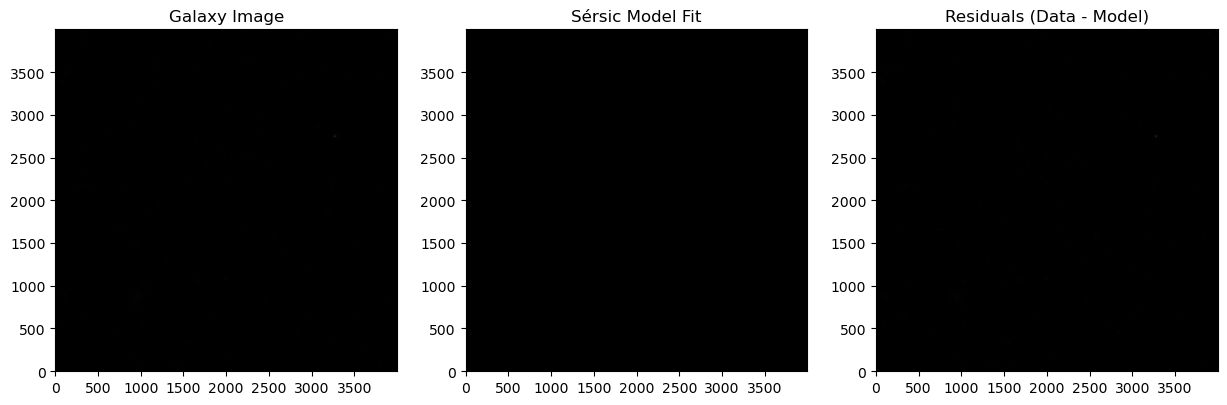

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.background import Background2D, MedianBackground
from photutils.centroids import centroid_2dg
from astropy.modeling import models, fitting

# ---- STEP 1: Load and Preprocess FITS File ---- #
fits_path = "/Users/wasi/Downloads/Castor-Madeline/CASTOR_AaronsCat_wide4_2019PSFs__FOV0_g_18000s_pixscale0p1.fits"

# Open FITS and store cropped section
with fits.open(fits_path, memmap=True) as hdul:
    raw_data = hdul[0].data  # Original full image
    data = raw_data[3000:7000, 10000:14000].astype('float32')  # Cropped region

# Clip negative values (optional but helpful)
data = np.clip(np.nan_to_num(data), 0, None)

# ---- STEP 2: Background Subtraction ---- #
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
data_sub = data - bkg.background  # Subtract background

# ---- STEP 3: Find Galaxy Centroid ---- #
y_peak, x_peak = centroid_2dg(data_sub)
print(f"Estimated Galaxy Center: ({x_peak:.2f}, {y_peak:.2f})")

# ---- STEP 4: Visualize Processed Image ---- #
plt.figure(figsize=(10, 8))
plt.imshow(data_sub, cmap='gray', origin='lower', vmin=0, vmax=np.percentile(data_sub, 99.9))
plt.colorbar(label='Background-Subtracted Flux (ADU)')
plt.title("Preprocessed FITS Image")
plt.show()

# ---- STEP 5: Fit Sérsic Model ---- #
sersic_model = models.Sersic2D(
    amplitude=np.percentile(data_sub, 90),  # Use 90th percentile instead of max
    r_eff=50.0,  # Initial guess for effective radius
    n=2.0,  # Initial Sérsic index guess
    x_0=x_peak,
    y_0=y_peak,
    ellip=0.3,  # Initial guess for ellipticity
    theta=0.0
)

# Fit Sérsic Profile
fitter = fitting.LevMarLSQFitter()
y, x = np.mgrid[:data_sub.shape[0], :data_sub.shape[1]]
fitted_model = fitter(sersic_model, x, y, data_sub)

# ---- STEP 6: Display Results ---- #
print(f"Best-fit Sérsic index (n): {fitted_model.n.value:.2f}")
print(f"Effective radius (r_eff): {fitted_model.r_eff.value:.2f} pixels")
print(f"Ellipticity: {fitted_model.ellip.value:.2f}")

# ---- STEP 7: Plot Fit vs. Data ---- #
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(data_sub, cmap='gray', origin='lower')
ax[0].set_title("Galaxy Image")
ax[1].imshow(fitted_model(x, y), cmap='gray', origin='lower')
ax[1].set_title("Sérsic Model Fit")
ax[2].imshow(data_sub - fitted_model(x, y), cmap='gray', origin='lower')
ax[2].set_title("Residuals (Data - Model)")
plt.show()


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_sources, SourceCatalog
from astropy.modeling import models, fitting

# ---- STEP 1: Load FITS File ---- #
fits_path = "/Users/wasi/Downloads/Castor-Madeline/CASTOR_AaronsCat_wide4_2019PSFs__FOV0_g_18000s_pixscale0p1.fits"

# Corrected FITS cropping
with fits.open(fits_path, memmap=True) as hdul:
    raw_data = hdul[0].data[8000:10000, 9000:11000].astype('float32')

# Clip negative values
data = np.clip(np.nan_to_num(raw_data), 0, None)

# ---- STEP 2: Background Subtraction ---- #
bkg_estimator = MedianBackground()
bkg = Background2D(data, (100, 100), filter_size=(5, 5), bkg_estimator=bkg_estimator)
data_sub = data - bkg.background

# ---- STEP 3: Source Detection ---- #
mean, median, std = sigma_clipped_stats(data_sub, sigma=2.0)

# Detect sources
threshold = median + (3.0 * std)
segm = detect_sources(data_sub, threshold, npixels=20)

# ---- STEP 4: Identify Galaxies (Shape Filtering) ---- #
catalog = SourceCatalog(data_sub, segm)
galaxies = []

for obj in catalog:
    elongation = obj.elongation
    area = obj.area.value
    ellipticity = obj.ellipticity

    # Keep extended sources (galaxies)
    if area > 50 and elongation > 1.5 and ellipticity > 0.2:
        galaxies.append((obj.xcentroid, obj.ycentroid))

print(f"Identified galaxies: {len(galaxies)}")

# ---- STEP 5: Sérsic Fitting for Each Galaxy ---- #
sersic_results = []
for i, (x_peak, y_peak) in enumerate(galaxies):
    print(f"Fitting Sérsic Model to Galaxy {i+1} at ({x_peak:.1f}, {y_peak:.1f})")

    crop_size = 100
    x_min, x_max = int(x_peak - crop_size), int(x_peak + crop_size)
    y_min, y_max = int(y_peak - crop_size), int(y_peak + crop_size)

    # Ensure within image bounds
    if x_min < 0 or y_min < 0 or x_max >= data_sub.shape[1] or y_max >= data_sub.shape[0]:
        print(f"Skipping galaxy {i+1}: Too close to image edge")
        continue

    galaxy_crop = data_sub[y_min:y_max, x_min:x_max]

    # ---- 🚀 Fix: Ensure No NaNs, Infs, or Negatives ---- #
    galaxy_crop = np.nan_to_num(galaxy_crop, nan=0.0, posinf=0.0, neginf=0.0)
    galaxy_crop = np.clip(galaxy_crop, 1e-3, None)  # Avoid log(0) errors

    # Sérsic Model
    x_0_fit = x_peak - x_min
    y_0_fit = y_peak - y_min

    sersic_model = models.Sersic2D(
        amplitude=np.percentile(galaxy_crop, 90),
        r_eff=20.0,
        n=2.0,
        x_0=x_0_fit,
        y_0=y_0_fit,
        ellip=0.3,
        theta=0.0
    )

    # Fit Sérsic Model
    fitter = fitting.LevMarLSQFitter()
    y, x = np.mgrid[:galaxy_crop.shape[0], :galaxy_crop.shape[1]]

    try:
        fitted_model = fitter(sersic_model, x, y, galaxy_crop)
        sersic_results.append((fitted_model.n.value, fitted_model.r_eff.value))
        print(f"  Sérsic Index (n) = {fitted_model.n.value:.2f}, Effective Radius = {fitted_model.r_eff.value:.2f} pixels")
    except Exception as e:
        print(f"🚨 Skipping galaxy {i+1}: Fitting failed with error {str(e)}")

# ---- STEP 6: Print Results ---- #
for i, (n, r_eff) in enumerate(sersic_results):
    print(f"Galaxy {i+1}: Sérsic Index = {n:.2f}, Effective Radius = {r_eff:.2f} pixels")


Identified galaxies: 28
Fitting Sérsic Model to Galaxy 1 at (1268.8, 66.2)
Skipping galaxy 1: Too close to image edge
Fitting Sérsic Model to Galaxy 2 at (1531.5, 80.0)
Skipping galaxy 2: Too close to image edge
Fitting Sérsic Model to Galaxy 3 at (351.3, 188.9)
  Sérsic Index (n) = 0.82, Effective Radius = 130.71 pixels
Fitting Sérsic Model to Galaxy 4 at (782.6, 245.9)


  Sérsic Index (n) = 1.35, Effective Radius = 549.18 pixels
Fitting Sérsic Model to Galaxy 5 at (1249.8, 260.3)
  Sérsic Index (n) = 0.74, Effective Radius = 451.94 pixels
Fitting Sérsic Model to Galaxy 6 at (22.8, 296.7)
Skipping galaxy 6: Too close to image edge
Fitting Sérsic Model to Galaxy 7 at (807.0, 299.1)
  Sérsic Index (n) = 2.39, Effective Radius = 438.34 pixels
Fitting Sérsic Model to Galaxy 8 at (1783.5, 342.5)
  Sérsic Index (n) = 2.97, Effective Radius = 291.50 pixels
Fitting Sérsic Model to Galaxy 9 at (567.5, 436.1)
  Sérsic Index (n) = 2.77, Effective Radius = 148.64 pixels
Fitting Sérsic Model to Galaxy 10 at (1176.6, 441.2)
  Sérsic Index (n) = 3.52, Effective Radius = 23.71 pixels
Fitting Sérsic Model to Galaxy 11 at (1007.3, 588.2)
  Sérsic Index (n) = 3.93, Effective Radius = 181.01 pixels
Fitting Sérsic Model to Galaxy 12 at (1009.5, 796.5)
  Sérsic Index (n) = 0.73, Effective Radius = 308.03 pixels
Fitting Sérsic Model to Galaxy 13 at (155.5, 854.0)
  Sérsic In

In [37]:
sersic_results

[(0.8162056098811756, 130.70946964882023),
 (1.3521887916460498, 549.1802815894315),
 (0.7388200200931323, 451.93838379423414),
 (2.392180201199169, 438.34161456501704),
 (2.9689841325551414, 291.4968651852088),
 (2.770866068117868, 148.64092682119323),
 (3.524402140388939, 23.70804678449317),
 (3.929111390644664, 181.00962983610572),
 (0.7253619847303547, 308.0280609810731),
 (1.2697409666859805, 484.22511199611773),
 (1.4642200449473848, 279.180304519098),
 (4.410469426314702, 99.73489203183911),
 (1.395853193605664, 289.8777285513115),
 (2.4381024546576193, 265.02994545493374),
 (1.2668766910773879, 511.7370827215846),
 (1.237663584281988, 232.13144257303037),
 (1.210130371541022, 423.3852097463383),
 (1.0345373743459967, 230.17242948244524),
 (4.080687215472433, 183.62205915985948),
 (2.985653450755903, 167.20299818949644)]